# This file contains image manipulation functions

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio.v2 as imageio

In [6]:
def show_image(img, title=None):
    """
        Display an image, using matplotlib.
        Handles grayscale and RGB
    """

    plt.figure(figsize=(8, 6))
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [7]:
def read_image(path):
    """
        Read an image from disk as RGB uint8
    """

    img = imageio.imread(path)
    if img.ndim == 2:
        return img #grayscale
    if img.shape[2] == 4:
        img = imt[..., :3] #drop alpha
    return img.astype(np.uint8)

In [8]:
def save_image(path, img):
    """
        Saves an image to disk also ensures dtype is uint8 and values are valid
    """

    if img.dtype != np.uint8:
        imt = np.clip(imt, 0, 255).astype(np.uint8) #float scale -> uint8
    imageio.imwrite(path, img)

shape:  (460, 460, 3) dtype:  uint8


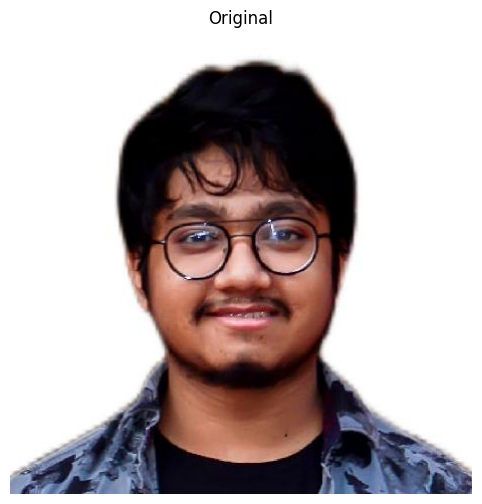

In [9]:
img = read_image('/home/arijit/Desktop/arijit.jpg')
print("shape: ", img.shape, "dtype: ", img.dtype)

show_image(img, 'Original')
str = "caption_here" 
save_image(f'/home/arijit/Desktop/{str}.jpg', img)

## Rotation 

## Image Rotation (Expert Notes)

### 1. Image Coordinate System

Images do **not** use the standard Cartesian coordinate system.

- Origin `(0, 0)` is at the **top-left**
- `x` increases to the **right**
- `y` increases **downward**

Pixel access in NumPy: img[y,x]


But geometric points are written as: (x, y)


This mismatch is important to remember.

---

## 2. Rotation in Mathematics (About the Origin)

A 2D rotation around the origin is defined as:

$$
R(\theta) =
\begin{bmatrix}
\cos\theta & -\sin\theta \\
\sin\theta & \cos\theta
\end{bmatrix}
$$

For a point:

$$
\mathbf{p} =
\begin{bmatrix}
x \\
y
\end{bmatrix}
$$

The rotated point is:

$$
\mathbf{p'} = R(\theta)\mathbf{p}
$$

---

## 3. Why This Is Not Enough for Images

Images are **not centered at the origin**.

For an image of width `w` and height `h`:

$$
c_x = \frac{w}{2}, \quad c_y = \frac{h}{2}
$$

Rotation must happen around `(c_x, c_y)`.

---

## 4. Rotating Around an Arbitrary Point

To rotate around a center point:

1. Translate center to origin
2. Rotate
3. Translate back

This is mathematically required.

---

## 5. Combined Transformation

The full transform becomes:

$$
\begin{bmatrix}
x' \\
y'
\end{bmatrix}
=
R(\theta)
\begin{bmatrix}
x \\
y
\end{bmatrix}
+
\begin{bmatrix}
t_x \\
t_y
\end{bmatrix}
$$

Where:

$$
t_x = c_x - c_x\cos\theta + c_y\sin\theta
$$

$$
t_y = c_y - c_x\sin\theta - c_y\cos\theta
$$

---

## 6. OpenCV Affine Matrix

OpenCV uses a 2×3 affine matrix:

$$
M =
\begin{bmatrix}
a & b & t_x \\
c & d & t_y
\end{bmatrix}
$$

For rotation:

$$
M =
\begin{bmatrix}
\cos\theta & -\sin\theta & t_x \\
\sin\theta & \cos\theta & t_y
\end{bmatrix}
$$

---

## 7. `cv2.getRotationMatrix2D`

This function:

- Computes rotation terms
- Computes translation terms
- Packs everything into a single affine matrix

It represents:
**translate → rotate → translate**, combined.

---

## 8. `cv2.warpAffine`

- Applies the affine transform to every pixel
- Uses inverse mapping
- Uses interpolation to avoid holes

Cropping happens if the output canvas is too small.

---

## 9. Key Mental Model

Image rotation is:

- Coordinate transformation
- Plus resampling
- Plus interpolation

The math is always there, even if hidden by the API.




In [10]:
def rotate(img, angle_deg, keep_size=False, border_value=0):
    """
    Rotate an image by angle_deg (degrees).
    
    keep_size=False: expands canvas so the whole rotated image fits (no cropping).
    keep_size=True: keeps original size (may crop).
    
    border_value: fill value for empty areas (0=black). For RGB, can be (0,0,0).
    """

    h, w = img.shape[:2]
    center = (w / 2, h / 2) # IMPORTANT: center is (x,y) = (w/2, h/2)

    # build the rotation matrix -> math behind rotation
    M = cv2.getRotationMatrix2D(center, angle_deg, 1.5)

    # if user wants to keep the original size, i.e. keep_size = True, the image may crop (corners may go out of bounds)
    # cv2.warpAffine() applies the transform matrix M to the image
    if keep_size:
        return cv2.warpAffine(img, M, (w, h), borderValue=border_value)
    
    # expanded canvas, i.e. keep_size = False
    # first we need to extract cos and sin from the matrix to compute the new required width/height
    # M[0,0] stores cosθ and M[0,1] stores -sinθ. we will take abs() coz size must be positive

    cos = abs(M[0, 0])
    sin = abs(M[0, 1])

    new_w = int(h * sin + w * cos)
    new_h = int(h * cos + w * sin)

    # now we will move our rotated image to the center of bigger canvas through "move" part of M {t_x, t_y}

    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]
    
    # ✅ “We are telling OpenCV: rotate around the old center, but place the result in the center of the new bigger image.”


    return cv2.warpAffine(img, M, (new_w, new_h), borderValue=border_value)
    

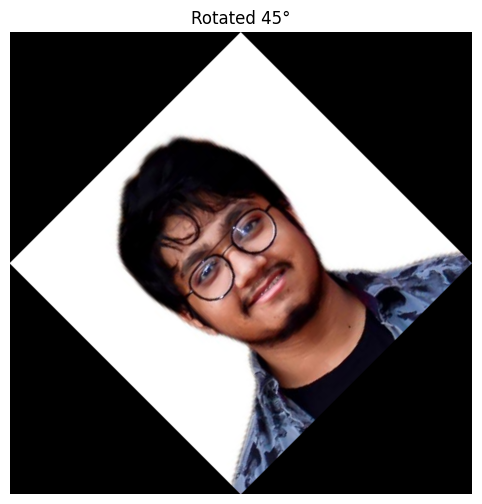

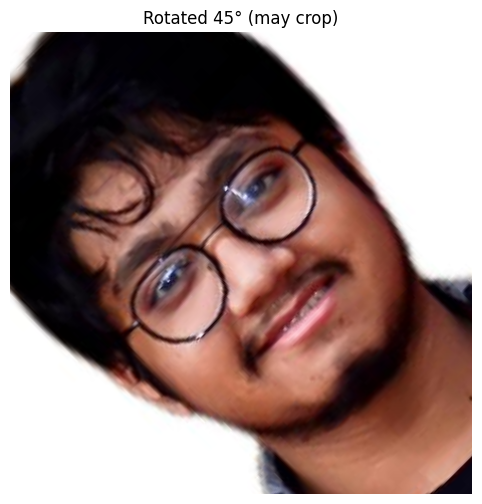

In [11]:
img_rot = rotate(img, 45, keep_size=False) #no cropping
show_image(img_rot, "Rotated 45°")
str = "rotated_no_crop"
save_image(f'/home/arijit/Desktop/{str}.jpg', img_rot)

img_rot_crop = rotate(img, 45, keep_size=True) #may crop
show_image(img_rot_crop, "Rotated 45° (may crop)")
str = "rotated_crop"
save_image(f'/home/arijit/Desktop/{str}.jpg', img_rot_crop)